<a href="https://colab.research.google.com/github/Priyanka-code-sys/DMML_1/blob/main/Sale_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Black Friday is an informal name given to Friday that is
accompanied by the Thanksgiving Day, celebrated on the
fourth Thursday of November in United States of America.
This day generally marks as the beginning of Christmas
Shopping Season in USA. During Black Friday Sale, many
shopping stores offer a highly promoted sales and give a huge
discount on a number of goods and services. At this point of
time of the year, retailers have high chances of getting the
biggest sale of the year

The Dataset for Black Friday sale prediction was taken from Kaggle.
The dataset was initially sourced from Analytics Vidhya(https://datahack.analyticsvidhya.com/contest/black-friday/#ProblemStatement) from the
Black Friday Contest.The dataset is in .csv file and contains 12
features and 5,50,069 rows. The model performance is measured
by the accuracy shown while predicting the purchase amount for
the test data(test.csv), that contains all the features same as that of
train data except the purchase amount which needs to be predicted.The objective is to develop a model to predict the purchasing capacity with respect to various products that would aid them in creating personalized offers for customers against different products along with understanding which areas make more sales during Black Friday.

# Importing and installing Libraries

In [15]:
pip install pywaffle

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import lightgbm
from lightgbm import LGBMRegressor
from sklearn.metrics import make_scorer
from pywaffle import Waffle

In [17]:
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Loading and Understanding Data

In [18]:
train_data = pd.read_csv("/content/drive/MyDrive/csv/train.csv")
test = pd.read_csv("/content/drive/MyDrive/csv/test.csv")

Checking the variable names and the first 5 rows of the data frame

In [19]:
train_data.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


Checking the information and data types of the variable of the data

In [20]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


Understanding the summary statistics of all variables in the data set
1. Most of the variables like occupation, Product categories in the dataset are masked with integers and City_Category is masked with alphabets
2. Product P00265242 is the most popular product! with 1880 occurences.
3. Male buyers are more frequent in the dataset than female buyers.
4. Age group with most transactions was 26-35.
5. Occupation '4' had the most transactions.
6. City Category with most transactions was B.
7. Highest number of purchasers had '1 year stay' in the current city.
8. Data set has more singles (Marital status 0) than married people (Marital status 1).


In [21]:
train_data.describe(include = 'all')

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,5.500680e+05,550068,550068,550068,550068.000000,550068,550068,550068.000000,550068.000000,376430.000000,166821.000000,550068.000000
unique,NaN,3631,2,7,NaN,3,5,NaN,NaN,NaN,NaN,NaN
top,NaN,P00265242,M,26-35,NaN,B,1,NaN,NaN,NaN,NaN,NaN
freq,NaN,1880,414259,219587,NaN,231173,193821,NaN,NaN,NaN,NaN,NaN
mean,1.003029e+06,NaN,NaN,NaN,8.076707,NaN,NaN,0.409653,5.404270,9.842329,12.668243,9263.968713
std,1.727592e+03,NaN,NaN,NaN,6.522660,NaN,NaN,0.491770,3.936211,5.086590,4.125338,5023.065394
min,1.000001e+06,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000,1.000000,2.000000,3.000000,12.000000
25%,1.001516e+06,NaN,NaN,NaN,2.000000,NaN,NaN,0.000000,1.000000,5.000000,9.000000,5823.000000
50%,1.003077e+06,NaN,NaN,NaN,7.000000,NaN,NaN,0.000000,5.000000,9.000000,14.000000,8047.000000
75%,1.004478e+06,NaN,NaN,NaN,14.000000,NaN,NaN,1.000000,8.000000,15.000000,16.000000,12054.000000


Checking the unique values in each of the variables. User ID and product ID have a lot unique categories and hence can't be used directly in the model. We need to explore what features can be extracted from these two columns.


In [22]:
train_data.nunique()

User_ID                        5891
Product_ID                     3631
Gender                            2
Age                               7
Occupation                       21
City_Category                     3
Stay_In_Current_City_Years        5
Marital_Status                    2
Product_Category_1               20
Product_Category_2               17
Product_Category_3               15
Purchase                      18105
dtype: int64

Checking the number of null values for each of the variables. Product category 2 and 3 have high proportion of nulls and we need to explore what can be done with these null values


In [23]:
train_data.isna().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
Purchase                           0
dtype: int64

# Data Visualization and Gathering Insights

Exploring the frequency distributions of all the columns. There are noticeable variations in the variables and this can be helpful in explaining the variation of the purchase amounts in the data set.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa90420a910>,
      dtype=object)

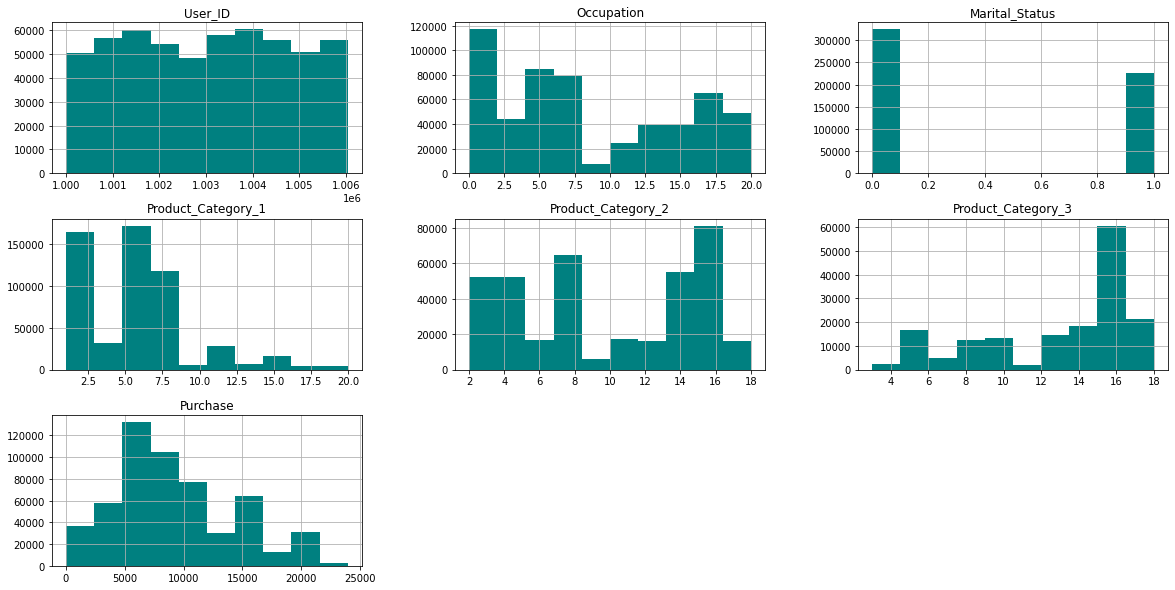

In [24]:
train_data.hist(figsize=(20,10), color = 'teal')

Average purchase value of single men is slightly higher than married people, while the trend is opposite in case of women !

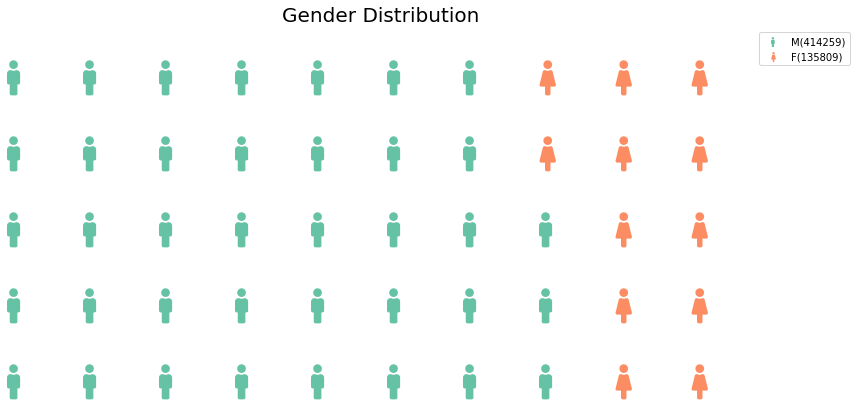

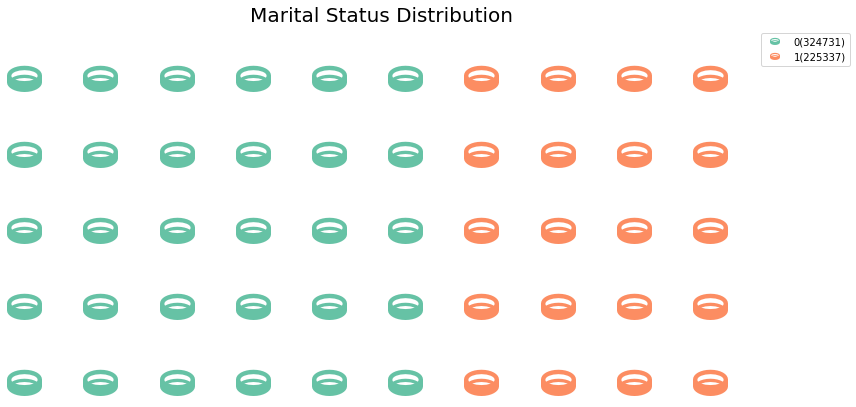

In [25]:
gender = train_data['Gender'].value_counts()

fig = plt.figure(
    FigureClass=Waffle, 
    rows=5,
    columns=10,
    values=gender,
    title={'label': 'Gender Distribution', 'loc': 'center','size':20},
    labels=["{}({})".format(a, b) for a, b in zip(gender.index, gender) ],
    legend={'loc': 'upper left', 'bbox_to_anchor': (1,1)},
    font_size=35, 
    icons = ['male','female'],
    icon_legend=True,
    figsize=(12, 8)
)
Marital_Status = train_data['Marital_Status'].value_counts()
fig = plt.figure(
    FigureClass=Waffle, 
    rows=5,
    columns=10,
    values=Marital_Status,
    title={'label': 'Marital Status Distribution', 'loc': 'center','size':20},
    labels=["{}({})".format(a, b) for a, b in zip(Marital_Status.index, Marital_Status) ],
    legend={'loc': 'upper left', 'bbox_to_anchor': (1,1)},
    font_size=35,
    icons = 'ring',
    icon_legend=True,
    figsize=(12, 8)
)

The variation in Gender can help us explain the variations in the purchase amount. However, variation in marital status is too little to explain any price variation in the purchase amounts. Average purchase value of single men is slightly higher than married people, while the trend is opposite in case of women !

Text(0.5, 1.0, 'Gender vs Marital Status Purchase Distribution')

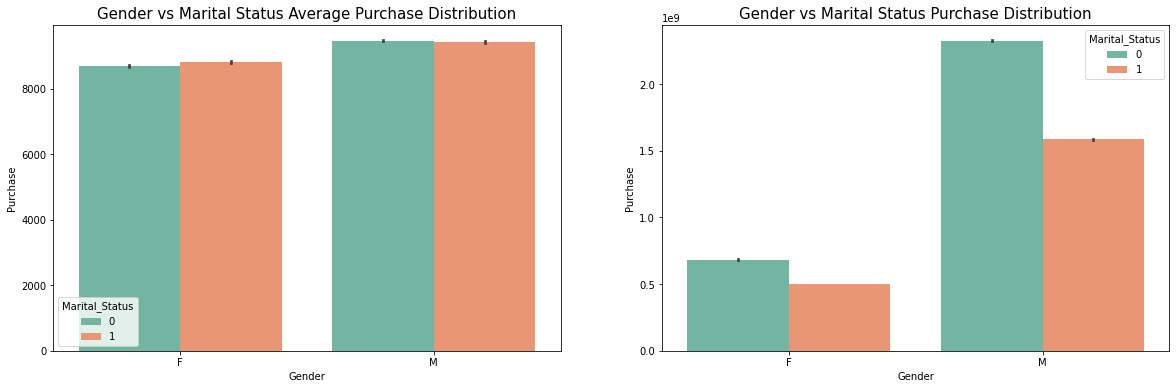

In [26]:
fig,ax = plt.subplots(figsize=(20,6),ncols=2,nrows=1)
sns.barplot(x="Gender",y="Purchase",hue="Marital_Status",estimator=np.mean,data=train_data,ax=ax[0] , palette="Set2").set_title(label = 'Gender vs Marital Status Average Purchase Distribution', size =15)
sns.barplot(x="Gender",y="Purchase",hue="Marital_Status",estimator=np.sum,data=train_data,ax=ax[1] , palette="Set2").set_title(label = 'Gender vs Marital Status Purchase Distribution', size =15)

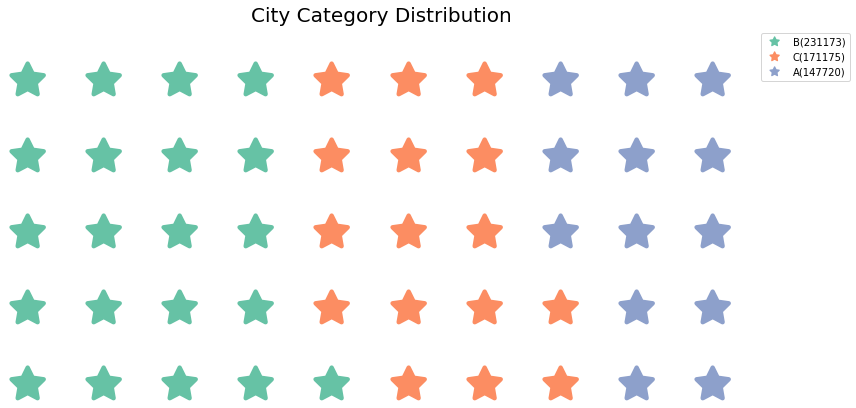

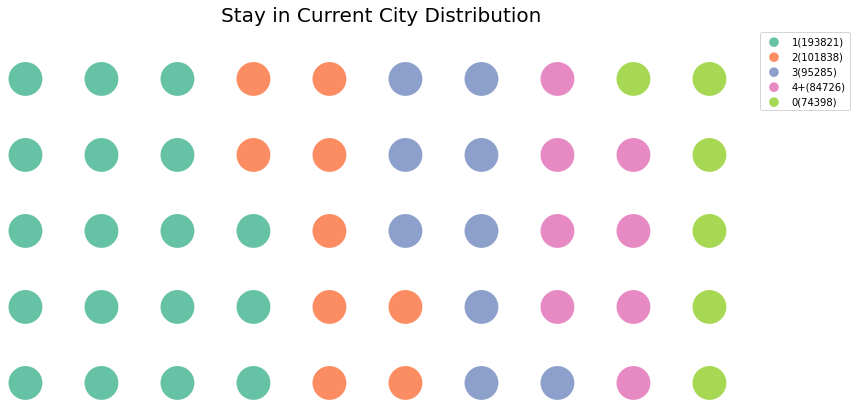

In [27]:
City = train_data['City_Category'].value_counts()
fig = plt.figure(
    FigureClass=Waffle, 
    rows=5,
    columns=10,
    values=City,
    title={'label': 'City Category Distribution', 'loc': 'center','size':20},
    labels=["{}({})".format(a, b) for a, b in zip(City.index, City) ],
    legend={'loc': 'upper left', 'bbox_to_anchor': (1,1)},
    font_size=35,
    icons = 'star',
    icon_legend=True,
    figsize=(12, 8)
)

Stay = train_data['Stay_In_Current_City_Years'].value_counts()
fig = plt.figure(
    FigureClass=Waffle, 
    rows=5,
    columns=10,
    values=Stay,
    title={'label': 'Stay in Current City Distribution', 'loc': 'center','size':20},
    labels=["{}({})".format(a, b) for a, b in zip(Stay.index, Stay) ],
    legend={'loc': 'upper left', 'bbox_to_anchor': (1,1)},
    font_size=35,
    icons = 'circle', 
    icon_legend=True,
    figsize=(12, 8)
)

Customers from city C buy products of higher purchase value, while stay is current city shows some variation!

Text(0.5, 1.0, 'City Category vs Stay in Current City Purchases Distribution')

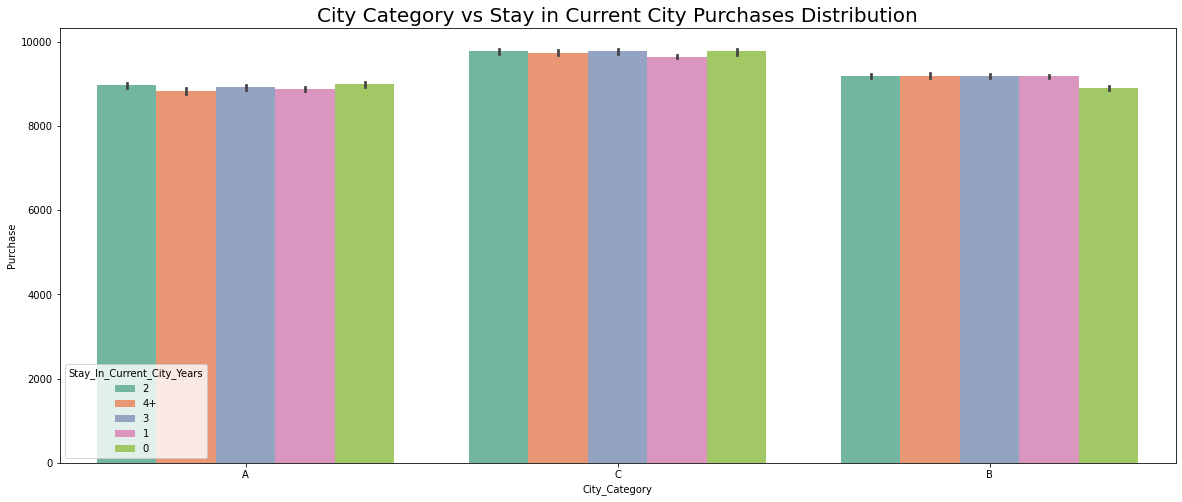

In [28]:
fig,ax = plt.subplots(figsize=(20,8),ncols=1,nrows=1)
sns.barplot(x="City_Category",y="Purchase",hue="Stay_In_Current_City_Years",estimator=np.mean,data=train_data, palette="Set2").set_title(label = 'City Category vs Stay in Current City Purchases Distribution', size =20)

Maximum number of purchasers are in the 26-35 age group, while the average purchase vs Age shows positive trend!

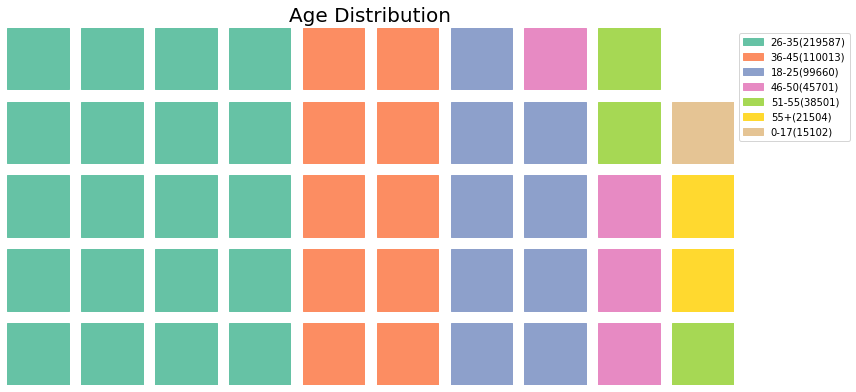

In [29]:

Age = train_data['Age'].value_counts()
fig = plt.figure(
    FigureClass=Waffle, 
    rows=5,
    columns=10,
    values=Age,
    title={'label': 'Age Distribution', 'loc': 'center','size':20},
    labels=["{}({})".format(a, b) for a, b in zip(Age.index, Age) ],
    legend={'loc': 'upper left', 'bbox_to_anchor': (1,1)},
    font_size=35,
    icon_legend=True,
    figsize=(12, 8)
)

Text(0.5, 1.0, 'Age bucket vs Average Purchase Distribution')

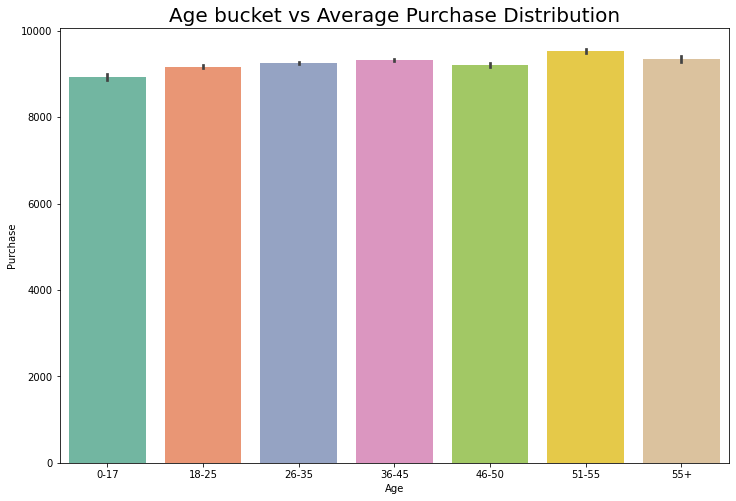

In [30]:
fig,ax = plt.subplots(figsize=(12,8),ncols=1,nrows=1)
sns.barplot(x="Age",y="Purchase",estimator=np.mean,data=train_data, palette="Set2", order=["0-17", "18-25","26-35","36-45","46-50","51-55","55+"]).set_title(label = 'Age bucket vs Average Purchase Distribution', size =20)

52% of sales are shared among 5 occupations while occupation wise average user spend shows some variation

<function matplotlib.pyplot.show>

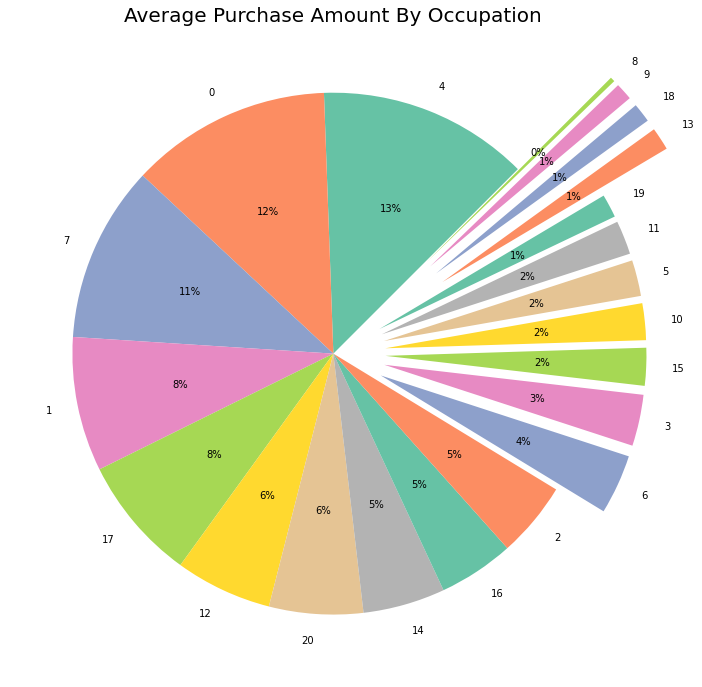

In [31]:
Occupation_percent =train_data.groupby('Occupation').Purchase.agg(['sum'])
Occupation_percent=Occupation_percent.apply(lambda x: 100 * x / float(x.sum())).reset_index()
Occupation_percent=Occupation_percent.sort_values(by = ['sum'],ascending=False)
explode = (0,0,0,0,0,0,0,0,0,0,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.5,0.5,0.5,0.5)
plt.figure(figsize=(20,12))
plt.pie(Occupation_percent['sum'],labels=Occupation_percent['Occupation'], explode= explode,autopct='%1.0f%%', counterclock=True,startangle=45, colors = sns.color_palette('Set2'))
plt.title(label= 'Average Purchase Amount By Occupation', loc = 'center', size = 20)
plt.show

Text(0.5, 1.0, 'Occupation vs Average Purchase Distribution')

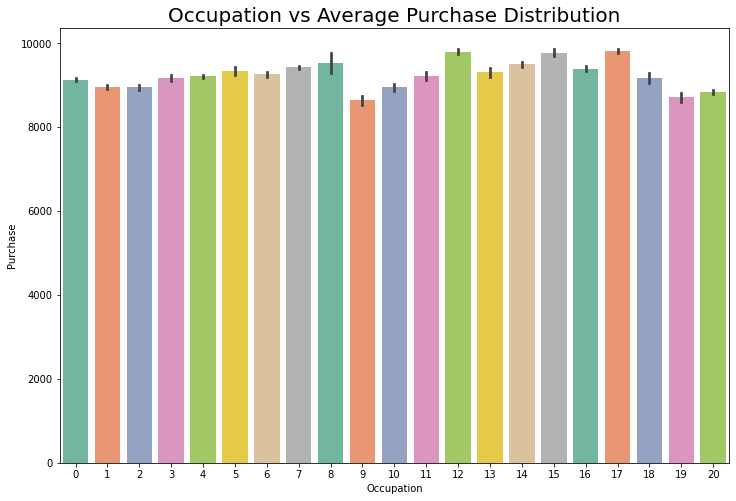

In [32]:
fig,ax = plt.subplots(figsize=(12,8),ncols=1,nrows=1)
sns.barplot(x="Occupation",y="Purchase",estimator=np.mean,data=train_data, palette="Set2").set_title(label = 'Occupation vs Average Purchase Distribution', size =20)

Number 10 in product category 1 has the maximum mean purchase value followed by Number 7. Number 5 is bought most frequently

Text(0.5, 1.0, 'Total Count Distribution In Product Category 1')

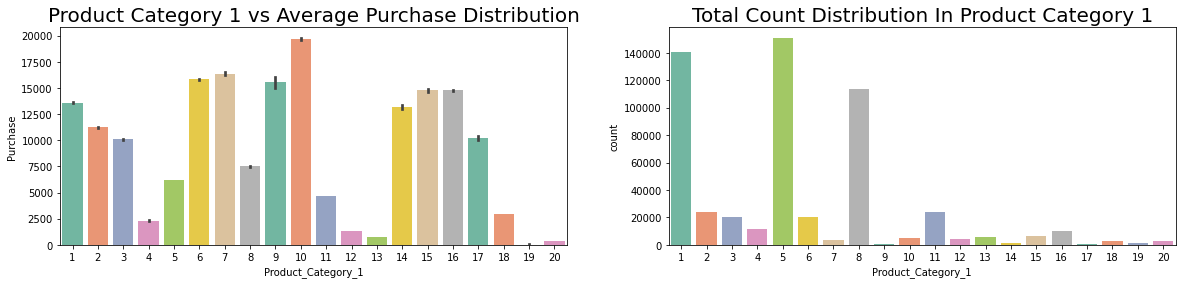

In [33]:
fig,ax = plt.subplots(figsize=(20,4),ncols=2,nrows=1)
sns.barplot(x="Product_Category_1",y="Purchase",estimator=np.mean,data=train_data,ax=ax[0], palette="Set2").set_title(label = 'Product Category 1 vs Average Purchase Distribution', size =20)
sns.countplot(x="Product_Category_1",data=train_data,ax=ax[1], palette="Set2").set_title(label = 'Total Count Distribution In Product Category 1', size =20)

Number 10 in product category 2 & number 3 in product category 2 has premium products with high average purchase value

Text(0.5, 1.0, 'Total Count Distribution In Product Category 2')

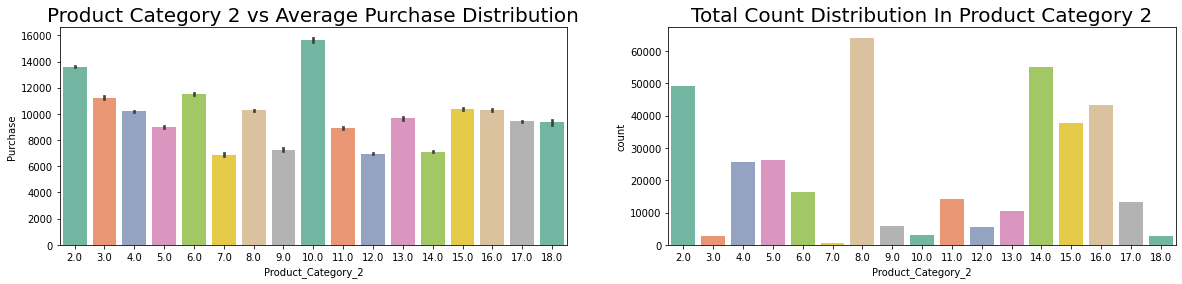

In [34]:
fig,ax = plt.subplots(figsize=(20,4),ncols=2,nrows=1)
sns.barplot(x="Product_Category_2",y="Purchase",estimator=np.mean,data=train_data,ax=ax[0], palette="Set2").set_title(label = 'Product Category 2 vs Average Purchase Distribution', size =20)
sns.countplot(x="Product_Category_2",data=train_data,ax=ax[1], palette="Set2").set_title(label = 'Total Count Distribution In Product Category 2', size =20)

Text(0.5, 1.0, 'Total Count Distribution In Product Category 3')

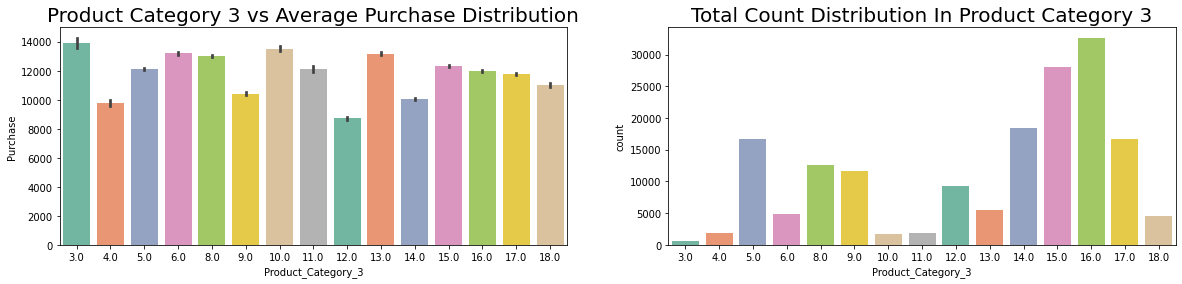

In [35]:
fig,ax = plt.subplots(figsize=(20,4),ncols=2,nrows=1)
sns.barplot(x="Product_Category_3",y="Purchase",estimator=np.mean,data=train_data,ax=ax[0], palette="Set2").set_title(label = 'Product Category 3 vs Average Purchase Distribution', size =20)
sns.countplot(x="Product_Category_3",data=train_data,ax=ax[1], palette="Set2").set_title(label = 'Total Count Distribution In Product Category 3', size =20)

50% of the times customer tends to buy a product with a purchase value between (5500,13000) during Black Friday

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


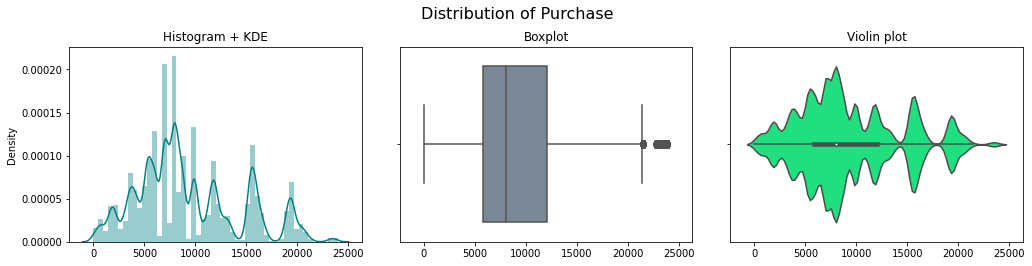

In [36]:
def triple_plot(x, title):
    fig, ax = plt.subplots(1,3,figsize=(15,4),sharex=True)
    sns.distplot(x, ax=ax[0], color = 'teal')
    ax[0].set(xlabel=None)
    ax[0].set_title('Histogram + KDE')
    sns.boxplot(x, ax=ax[1], color = 'lightslategrey')
    ax[1].set(xlabel=None)
    ax[1].set_title('Boxplot')
    sns.violinplot(x, ax=ax[2], color = 'springgreen')
    ax[2].set(xlabel=None)
    ax[2].set_title('Violin plot')
    fig.suptitle(title, fontsize=16)
    plt.tight_layout(pad=3.0)
    plt.show()
triple_plot(train_data['Purchase'],'Distribution of Purchase')

# Data Processing

Creating initial file for Submission

In [37]:
submission = test[['User_ID','Product_ID']]

Splitting the input train data into Train and Development data, to train the data on train and test it on development data. And then use that model for predictions on the test. Started with 80-20 split and after fitting the model, used 99% of the data for final predictions.

In [38]:
train = train_data.sample(frac=0.999,random_state=0) #random state is a seed value
dev = train_data.drop(train.index)

Converting Age and Stay in Current City Buckets to numbers so as to cast the data from categorical type to numeric

In [39]:
train['Age'] = train['Age'].replace(['0-17','18-25','26-35','36-45','46-50','51-55','55+'],[9,22,31,41,48,53,60])
train['Stay_In_Current_City_Years'] = train['Stay_In_Current_City_Years'].replace(['4+'],[5])

dev['Age'] = dev['Age'].replace(['0-17','18-25','26-35','36-45','46-50','51-55','55+'],[9,22,31,41,48,53,60])
dev['Stay_In_Current_City_Years'] = dev['Stay_In_Current_City_Years'].replace(['4+'],[5])

test['Age'] = test['Age'].replace(['0-17','18-25','26-35','36-45','46-50','51-55','55+'],[9,22,31,41,48,53,60])
test['Stay_In_Current_City_Years'] = test['Stay_In_Current_City_Years'].replace(['4+'],[5])

Converting Categories to Numerical type because LightGBM expects the categorical data to be encoded as numbers

In [40]:
train['Gender'] = train['Gender'].replace(['M','F'],[0,1])
train['City_Category'] = train['City_Category'].replace(['A','B','C'],[1,2,3])

dev['Gender'] = dev['Gender'].replace(['M','F'],[0,1])
dev['City_Category'] = dev['City_Category'].replace(['A','B','C'],[1,2,3])

test['Gender'] = test['Gender'].replace(['M','F'],[0,1])
test['City_Category'] = test['City_Category'].replace(['A','B','C'],[1,2,3])

There are a lot of missing values in Product Category to 2,3. Instead of imputing all of them, creating a new category '0'. Tried using the mode, but using it as new category gave the best score

In [41]:
train = train.fillna(0)
dev = dev.fillna(0)
test = test.fillna(0)

As we have to drop User ID and Product ID columns, created new features with approximately resembles them. Average Cost of Products for Product ID and Buying Power (total amount spent) for User ID. Test data doesn't have the price data to calculate this, so using the data from train to impute it in Test and Dev. If there are any new users in Test or Dev, we are imputing it with Global averages.

In [42]:
train['Average_Cost'] = train.groupby(['Product_ID'])['Purchase'].transform('mean')
train['Buying_Power'] =  train.groupby(['User_ID'])['Purchase'].transform('mean')

product_price = train[['Average_Cost','Product_ID']].drop_duplicates()
average_cost = product_price['Average_Cost'].mean()
print("Average Cost of Products is ", average_cost)

user_buying_power =  train[['Buying_Power','User_ID']].drop_duplicates()
buying_power = user_buying_power['Buying_Power'].mean()
print("Average Buying Power of users is ", buying_power)

Average Cost of Products is  7874.904788143822
Average Buying Power of users is  9568.92548706315


In [43]:
print("Dev dimensions before adding features ", dev.shape)
print("Test dimensions before adding features ", test.shape)

dev = dev.merge(product_price, how = 'left', left_on = 'Product_ID',right_on = 'Product_ID')
dev = dev.merge(user_buying_power, how = 'left', left_on = 'User_ID',right_on = 'User_ID')

test = test.merge(product_price, how = 'left', left_on = 'Product_ID',right_on = 'Product_ID')
test = test.merge(user_buying_power, how = 'left', left_on = 'User_ID',right_on = 'User_ID')

print("Dev dimensions after adding features ", dev.shape)
print("Test dimensions after adding features ", test.shape)

Dev dimensions before adding features  (550, 12)
Test dimensions before adding features  (233599, 11)
Dev dimensions after adding features  (550, 14)
Test dimensions after adding features  (233599, 13)


In [44]:
print("Nulls in Dev before imputing features ", dev.isna().sum())
print("Nulls in Test before imputing features ", test.isna().sum())

dev['Average_Cost']  = dev['Average_Cost'].fillna(average_cost)
dev['Buying_Power']  = dev['Buying_Power'].fillna(buying_power)

test['Average_Cost']  = test['Average_Cost'].fillna(average_cost)
test['Buying_Power']  = test['Buying_Power'].fillna(buying_power)

print("Nulls in Dev after imputing features ", dev.isna().sum())
print("Nulls in Test after imputing features ", test.isna().sum())

Nulls in Dev before imputing features  User_ID                       0
Product_ID                    0
Gender                        0
Age                           0
Occupation                    0
City_Category                 0
Stay_In_Current_City_Years    0
Marital_Status                0
Product_Category_1            0
Product_Category_2            0
Product_Category_3            0
Purchase                      0
Average_Cost                  0
Buying_Power                  0
dtype: int64
Nulls in Test before imputing features  User_ID                        0
Product_ID                     0
Gender                         0
Age                            0
Occupation                     0
City_Category                  0
Stay_In_Current_City_Years     0
Marital_Status                 0
Product_Category_1             0
Product_Category_2             0
Product_Category_3             0
Average_Cost                  61
Buying_Power                   0
dtype: int64
Nulls in Dev after

Creating a list of categorical columns, which can be used as input for LightGBM

In [45]:
categorical_columns = ["Gender", "Occupation", "City_Category", "Stay_In_Current_City_Years",
                       "Marital_Status", "Product_Category_1", "Product_Category_2", "Product_Category_3"]

Commented out the Hot encoding code, as these are required only for Linear Regression, Decision Tree and Random Forest. LightGBM has an internal way of handling categorical data 

In [46]:
# train = pd.get_dummies(train, columns= categorical_columns)
# dev = pd.get_dummies(dev, columns= categorical_columns)
# test = pd.get_dummies(test, columns= categorical_columns)

# for i in list(train.columns):
#     if i not in list(dev.columns):
#         dev[i] = 0
#     if i not in list(test.columns):
#         test[i] = 0

Dropping the User ID and Product ID columns

In [47]:
train = train.drop(columns =['User_ID','Product_ID'])
dev = dev.drop(columns =['User_ID','Product_ID'])
test = test.drop(columns =['User_ID','Product_ID'])

Bringing the Target Column to the last and commented out the code, which is not required for LightGBM

In [48]:
train = train[ [ col for col in train.columns if col != 'Purchase' ] + ['Purchase'] ]
# dev = dev[train.columns]
# test = test[train.columns]
# test = test.drop(columns =['Purchase'])

Checking correlation of numerical variables

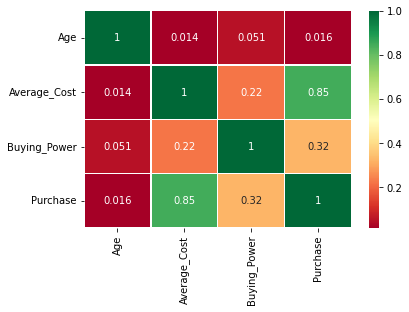

In [49]:
sns.heatmap(train[ [ col for col in train.columns if col not in categorical_columns ]].corr(),annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':10})
#run this only with LightGBM Columns

Checking scatter plots of numerical variables

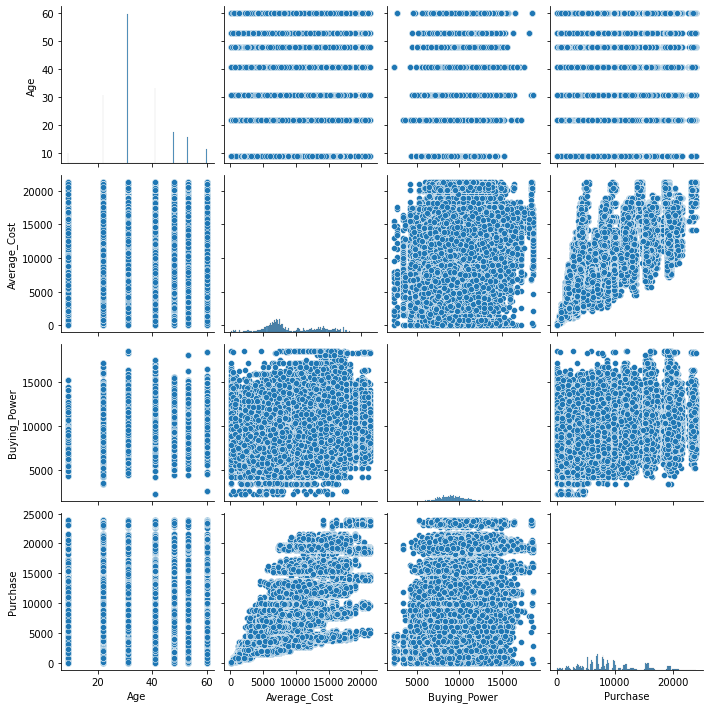

In [50]:
sns.pairplot(train[ [ col for col in train.columns if col not in categorical_columns ]], palette = 'Set2') #run this only with LightGBM Columns

Creating the datasets for modelling

In [51]:
X_train = train.iloc[:,:-1].values
X_dev = dev.iloc[:,:-1].values
y_train = train.iloc[:,-1].values
y_actual = dev.iloc[:,-1].values

X_test = test.iloc[:,:].values

Scaling the data based on the traingdata so that all columns are in the same range 

In [52]:
Scaler = StandardScaler()

Scaler.fit(X_train)
X_train = Scaler.transform(X_train)
X_dev = Scaler.transform(X_dev)
X_test = Scaler.transform(X_test)

# Train, Predict and Test Model Performance

Creating a scorer to measure the model performance

In [53]:
def rmse(predictions, targets): 
  return np.sqrt(((predictions - targets) ** 2).mean())

rmse_score = make_scorer(rmse, greater_is_better=False)

Ran all the basic models to check RSME and selected the model with highest score to  perform further Hypertuning

In [71]:
reg = LinearRegression()
reg.fit(X_train,y_train)
y_pred = reg.predict(X_dev)
print("Linear Regression RMSE on 20% data is ", rmse(y_pred,y_actual))


Linear Regression RMSE on 20% data is  6181.244063910624


In [65]:
reg = DecisionTreeRegressor()
reg.fit(X_train,y_train)
y_pred = reg.predict(X_dev)
print("Decision Tree Regressor RMSE on 20% data is ", rmse(y_pred,y_actual))

Decision Tree Regressor RMSE on 20% data is  6322.578212775902


In [64]:
reg = RandomForestRegressor()
reg.fit(X_train,y_train)
y_pred = reg.predict(X_dev)
print("Random Forest Regressor RMSE on 20% data is ", rmse(y_pred,y_actual))

Random Forest Regressor RMSE on 20% data is  5512.700731999993


In [66]:
reg = LGBMRegressor(metric = 'rsme')
reg.fit(X_train,y_train)
y_pred = reg.predict(X_dev)
print("LightGBM RMSE on 20% data is ", rmse(y_pred,y_actual))

LightGBM RMSE on 20% data is  5491.420556909756


Light GBM gave us the best score. We will further tune this model to improve model performance along with Cross Validation over 4 folds

Performing a step wise grid search for tuning the model

In [73]:
lgb = LGBMRegressor(metric = 'rmse', categorical_columns = categorical_columns,subsample = 0.5, num_leaves = 500, num_iterations =200,  random_state=0 )
param_test ={'learning_rate' : [0.05,0.1,0.2,0.3]}

Total_sets = 100

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
gs = RandomizedSearchCV(
    estimator=lgb, param_distributions=param_test, 
    n_iter=Total_sets,
    scoring=rmse_score,
    cv=4,
    refit=True,
    random_state=314,
    n_jobs = 4,
    verbose=True)
gs.fit(X_train, y_train)
print('Best score reached: {} with params: {} '.format(-1*gs.best_score_, gs.best_params_))
y_pred  = gs.predict(X_dev)
score =  rmse(y_pred,y_actual)
y_test = gs.predict(X_test)
submission['Purchase'] = pd.DataFrame(y_test) 
submission.to_csv("../submission_jupyter.csv")

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Best score reached: 2449.0056744478607 with params: {'learning_rate': 0.1} 


In [74]:
r=pd.read_csv('../submission_jupyter.csv')

In [75]:
r.head(5)

,Unnamed: 0,User_ID,Product_ID,Purchase
0,0,1000004,P00128942,17090.216307
1,1,1000009,P00113442,11721.637195
2,2,1000010,P00288442,6922.277657
3,3,1000010,P00145342,2537.950846
4,4,1000011,P00053842,2403.874928


In [59]:
lgb = LGBMRegressor(metric = 'rmse', categorical_columns = categorical_columns,subsample = 0.5, num_leaves = 500, num_iterations =200,  random_state=0,learning_rate = 0.1)
lgb.fit(X_train, y_train)
y_predicted = lgb.predict(X_train)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


This solution gave a rank in the Top 10 percentile in the Hackathon

Plotting the feature importance. As expected, Average Cost and Buying Power are the features with highest importance. As seen in the visualization- City, Stay in city, Marital Status, Gender did not have a lot of variance which led to a lower effect on Purchase Amount. Occupation and Product Categories also had significant effect on Purchase amount.

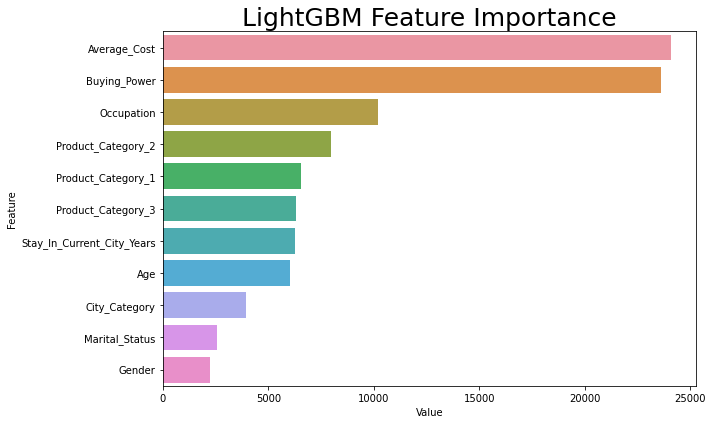

In [67]:
sorted(zip(lgb.feature_importances_, train.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(lgb.feature_importances_,train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(10, 6))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title(label= 'LightGBM Feature Importance', size = 25)
plt.tight_layout()
plt.show()

Checking the Scatter of Purchase vs Predicted Purcahse for the complete dataset

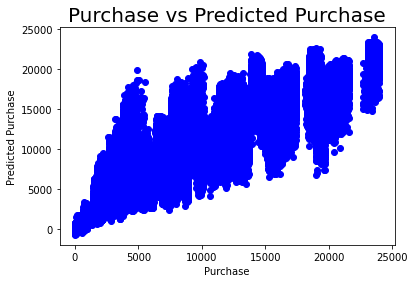

In [68]:
plt.scatter(y_train, y_predicted, c = 'blue')
plt.xlabel("Purchase")
plt.ylabel("Predicted Purchase")
plt.title(label = "Purchase vs Predicted Purchase", size = 20)
plt.show()

Checking the Scatter of Purchase vs Residual for the complete dataset

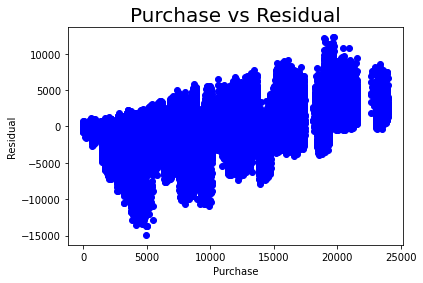

In [69]:
plt.scatter(y_train, y_train -y_predicted, c = 'blue')
plt.xlabel("Purchase")
plt.ylabel("Residual")
plt.title(label = "Purchase vs Residual", size = 20)
plt.show()